In [1]:
# %pip install torch torchvision scikit-learn pandas matplotlib

# 1. Data preprocessing

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [3]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Define Domains
df1['domain'], df2['domain'] = 0, 1

# Split set 1
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=0.2)
# Split set 2
x2_1 = df2[df2['label'] == 1].sample(500, random_state=0)
x2_0 = df2[df2['label'] == 0].sample(500, random_state=0)
df2_train = df2[[i not in list(pd.concat([x2_1, x2_0]).reset_index()['index']) for i in df2.index]].reset_index(drop=True)
df2_dev = pd.concat([x2_1,x2_0]).reset_index(drop=True)

# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
train_set = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in train_set['text']], train_set['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

# Print classes proportion
print(round(train_set['label'].value_counts()/len(train_set['label']),2))

label
0    0.81
1    0.19
Name: count, dtype: float64


# 2. Encoding

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import time

st = time.time()
# Cvec encoding
Cvec = CountVectorizer(ngram_range=(8,8))
x_train = Cvec.fit_transform(x_tr)
x_dev = Cvec.transform(x_dev)
et = time.time()
print(f'Elapsed time: {et-st:.3f}')

Elapsed time: 12.915


# 3 DL Models (Embeding model)

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [6]:
# Weights function
def weights(df):
    w = list(len(df['label'])/df['label'].value_counts())
    sample_weights = [0] * df.shape[0]
    for idx, label in enumerate(df['label']):
        sample_weights[idx] = w[label]
    return sample_weights

# Prepare pytorch dataset
class SparseDataset(Dataset):

    def __init__(self, mat_csc, label, device='cpu'):
        self.dim = mat_csc.shape
        self.device = torch.device(device)
        csr = mat_csc.tocsr(copy=True)
        # csr indptr, indices and data
        self.indptr = torch.tensor(csr.indptr, dtype=torch.int64, device=self.device)
        self.indices = torch.tensor(csr.indices, dtype=torch.int64, device=self.device)
        self.data = torch.tensor(csr.data, dtype=torch.float32, device=self.device)
        # df label
        self.label = torch.tensor(label, dtype=torch.float32, device=self.device)
    def __len__(self):
        return self.dim[0]
    def __getitem__(self, idx):
        obs = torch.zeros((self.dim[1],), dtype=torch.float32, device=self.device)
        ind1,ind2 = self.indptr[idx],self.indptr[idx+1]
        obs[self.indices[ind1:ind2]] = self.data[ind1:ind2]
        return obs,self.label[idx]

# Define collate (pre_process) function
def collate_batch(batch):  
    texts, labels = zip(*batch)
    text_len = [len(txt) for txt in texts]
    text = nn.utils.rnn.pad_sequence(texts, batch_first=True).to(device)
    labels = torch.tensor(labels, dtype=torch.float32).to(device).reshape(-1,1)
    return text, labels, text_len, domain

# Create datasets
train_DS = SparseDataset(x_train, y_train.values, device)
dev_DS = SparseDataset(x_dev, y_dev.values, device)

# Sample train data
sampler_tr = torch.utils.data.WeightedRandomSampler(weights(train_set), num_samples=len(train_DS), replacement=True)

# Create dataloaders
bs = 32
x_tr_dl = DataLoader(train_DS, batch_size=bs, sampler=sampler_tr)
x_dev_dl = DataLoader(dev_DS, batch_size=bs)

In [7]:
from torch import nn
class BowNetwork(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.first_layer = nn.Linear(vocab_size, hidden_dim) 
        nn.init.uniform_(self.first_layer.weight)
        self.second_layer = nn.Linear(hidden_dim, hidden_dim)
        self.third_layer = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(x)
        x = torch.relu(self.first_layer(x)) 
        x = torch.relu(self.second_layer(x))
        logits = self.third_layer(x)
        return self.dropout(logits)

In [8]:
vocab_size = x_train.shape[1]
bow_model = BowNetwork(vocab_size, 64).to(device)
print(bow_model)

BowNetwork(
  (first_layer): Linear(in_features=2576348, out_features=64, bias=True)
  (second_layer): Linear(in_features=64, out_features=64, bias=True)
  (third_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [9]:
# Optimizer
optimizer = torch.optim.Adam(bow_model.parameters())

def weights_class(y):
    y = pd.Series(y.int().numpy(force=True).reshape(-1))
    w = len(y)/y.value_counts()
    try:
        return w[1]
        
    except:
        return 1

In [10]:
from sklearn.metrics import f1_score
from tqdm import tqdm
# Train
def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, total, acc, real, preds = 0, 0, 0, [], []
    for X, y in tqdm(dataloader):
        pred = model(X).reshape(-1)                                             # Forward pass
        loss_fn = nn.BCEWithLogitsLoss(weight = torch.tensor(weights_class(y)).to(device))
        loss = loss_fn(pred, y)                                     # Compute loss 
        loss.backward()                                             # Backpropagation
        optimizer.step()                                            # Update parameters
        optimizer.zero_grad()                                       # Reset gradient
        # Metrics
        pr = torch.sigmoid(pred)
        acc += torch.sum((pr>=0.5).float() == y)
        real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        preds.extend((pr>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        train_loss += loss.item()
        total += len(y)
    # General metrics
    train_loss /= total
    return train_loss, acc/size, f1_score(real, preds)

In [11]:
# Test
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, total, acc, real, preds = 0, 0, 0, [], []
    with torch.no_grad():       # Specify no gradient
        for X, y in dataloader:
            
            pred = model(X).reshape(-1)                                         # Forward pass
            loss_fn = nn.BCEWithLogitsLoss(weight = torch.tensor(weights_class(y)).to(device))
            
            # Metrics
            pr = torch.sigmoid(pred)
            acc += torch.sum((pr>=0.5).float() == y)
            real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            preds.extend((pr>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            
            test_loss += loss_fn(pred, y).item()    # Compute loss  
            total += len(y)                         # Total observations

    # General metrics
    test_loss /= total
    return test_loss, acc/size, f1_score(real, preds)

In [12]:
from tqdm import tqdm # show progress bar

# Epochs
epochs = 9
train_loss, valid_loss = [], []
print("Training BOW feedforward network model!")
for t in range(epochs):
    tl, train_acc, f1_tr = train(x_tr_dl, bow_model, optimizer)
    vl, valid_acc, f1_ts = test(x_dev_dl, bow_model)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)
    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )
    tqdm.write(
        f'epoch #{t}\tf1_tr: {f1_tr:.3f}\t\tf1_ts: {f1_ts:.3f}',
    )

Training BOW feedforward network model!


100%|██████████| 500/500 [00:16<00:00, 29.53it/s]


epoch #0	train_acc: 0.716	valid_acc: 0.779
epoch #0	f1_tr: 0.718		f1_ts: 0.811


100%|██████████| 500/500 [00:16<00:00, 30.01it/s]


epoch #1	train_acc: 0.917	valid_acc: 0.908
epoch #1	f1_tr: 0.920		f1_ts: 0.910


100%|██████████| 500/500 [00:16<00:00, 29.81it/s]


epoch #2	train_acc: 0.936	valid_acc: 0.912
epoch #2	f1_tr: 0.939		f1_ts: 0.914


100%|██████████| 500/500 [00:16<00:00, 29.73it/s]


epoch #3	train_acc: 0.948	valid_acc: 0.923
epoch #3	f1_tr: 0.950		f1_ts: 0.924


100%|██████████| 500/500 [00:16<00:00, 29.81it/s]


epoch #4	train_acc: 0.944	valid_acc: 0.923
epoch #4	f1_tr: 0.946		f1_ts: 0.924


100%|██████████| 500/500 [00:16<00:00, 29.82it/s]


epoch #5	train_acc: 0.948	valid_acc: 0.926
epoch #5	f1_tr: 0.951		f1_ts: 0.927


100%|██████████| 500/500 [00:16<00:00, 29.85it/s]


epoch #6	train_acc: 0.949	valid_acc: 0.926
epoch #6	f1_tr: 0.950		f1_ts: 0.927


100%|██████████| 500/500 [00:16<00:00, 29.91it/s]


epoch #7	train_acc: 0.952	valid_acc: 0.928
epoch #7	f1_tr: 0.954		f1_ts: 0.929


100%|██████████| 500/500 [00:16<00:00, 29.70it/s]


epoch #8	train_acc: 0.950	valid_acc: 0.930
epoch #8	f1_tr: 0.953		f1_ts: 0.931


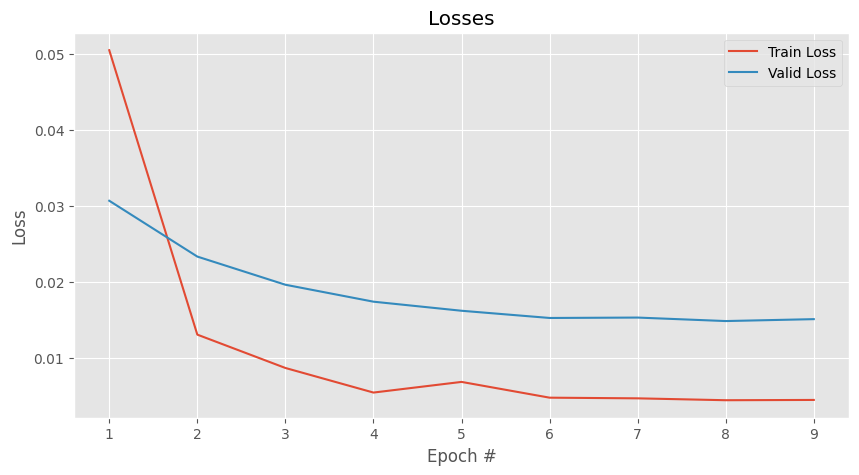

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, t + 2)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# Predict on sample data

In [14]:
# Predict on sample data
# Read data
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in pd.read_json('../Data/test_data.json', lines=True)['text']]
# Encoding
x_test = Cvec.transform(test)
test_DS = SparseDataset(x_test, [0] * len(test), device)
ts_dl = DataLoader(test_DS, batch_size=32)
# x_dev_dl

In [15]:
# predict on data
preds = []
for batch in iter(x_dev_dl):
    x_test, y = batch
    # Predict
    pr = torch.sigmoid(bow_model(x_test).reshape(-1))
    test_pred = [int(i) for i in (pr>0.49).int()]
    preds.extend(test_pred)

In [26]:
from sklearn.metrics import roc_auc_score
print(f'Accuracy: {sum(np.array(preds) == y_dev)/len(y_dev):.3f}\
        F1 Score: {f1_score(y_dev, preds):.3f}\
        ROC_AUC: {roc_auc_score(y_dev, preds):.3f}')

Accuracy: 0.928        F1 Score: 0.929        ROC_AUC: 0.929


In [17]:
# Create DF
df = pd.DataFrame([[i,j] for i,j in enumerate(preds)], columns=['id', 'class'])
# Save file
df.to_csv('../Data/predictions_BOWNN.csv', index=False)

# DATA EXPLORATION

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [19]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

df1['domain'], df2['domain'] = 0, 1
df3 = pd.concat([df1, df2])

In [20]:
# Data oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Split d1
df1_train, df1_dev = train_test_split(df1, random_state=42, test_size=1000)
# Split d2
df_2_0 = df2[df2['label'] == 0].sample(n=500, random_state=42)
df_2_1 = df2[df2['label'] == 1].sample(n=500, random_state=42)
df2_train = df2[[i not in pd.concat([df_2_0, df_2_1]).index for i in df2.index]].reset_index(drop=True)
df2_train = pd.concat([df2_train[df2_train['label'] == 0].sample(n=2000, random_state=42), df2_train[df2_train['label'] == 1]])  ####
df2_dev = pd.concat([df_2_0, df_2_1]).reset_index(drop=True)

# # transform the dataset
sampler = RandomOverSampler()
df2_train, _ = sampler.fit_resample(df2_train, df2_train['label'])

# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
df3_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in df3_train['text']], df3_train['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # Cvec encoding
# Cvec = CountVectorizer(ngram_range=(1,3))
# x_train = Cvec.fit_transform(x_tr)
# x_dev = Cvec.transform(x_dev)

# Tvec encoding
Tvec = TfidfVectorizer()
x_train = Tvec.fit_transform(x_tr)
# x_dev = Tvec.transform(x_dev)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(3, svd_solver='arpack')
comps = pca.fit_transform(StandardScaler(with_mean=False).fit_transform(x_train))

# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=3)
# comps = svd.fit_transform(x_train)

# from sklearn.cross_decomposition import PLSCanonical
# plsca = PLSCanonical(n_components=1)
# comps = plsca.fit(x_train.toarray(), y_train)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# t-SNE
perplexity = 150
t_sne = TSNE(n_components=2, perplexity=perplexity, init="random")
comps = t_sne.fit_transform(x_train)

plt.scatter(comps.T[0], comps.T[1], c= df3_train['label'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = comps.T[0]
    ys = comps.T[1]
    zs = comps.T[2]
    ax.scatter(xs, ys, zs, marker=m, c=df3['label'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

In [ ]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Define Domains
df1['domain'], df2['domain'] = 0, 1

# Split set 1
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=0.2)
# Split set 2
x2_1 = df2[df2['label'] == 1].sample(500, random_state=0)
x2_0 = df2[df2['label'] == 0].sample(500, random_state=0)
df2_train = df2[[i not in list(pd.concat([x2_1, x2_0]).reset_index()['index']) for i in df2.index]].reset_index(drop=True)
df2_dev = pd.concat([x2_1,x2_0]).reset_index(drop=True)

# Join data in both domains for trating them jointly (Augmentation)
dev_set = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)
train_set = pd.concat([df1_train, df2_train]).reset_index(drop=True)

# Train and dev sets
x_tr, y_train = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in train_set['text']], train_set['label']
x_dev, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in dev_set['text']], dev_set['label']

# Print classes proportion
print(round(train_set['label'].value_counts()/len(train_set['label']),2))

# 2. Encoding

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import time

st = time.time()
# Cvec encoding
Cvec = CountVectorizer(ngram_range=(8,9))
x_train = Cvec.fit_transform(x_tr)
x_dev = Cvec.transform(x_dev)
et = time.time()
print(f'Elapsed time: {et-st:.3f}')

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# t-SNE
perplexity = 100
t_sne = TSNE(n_components=2, perplexity=perplexity, init="random")
comps = t_sne.fit_transform(x_train)

plt.scatter(comps.T[0], comps.T[1], c= y_train, s=0.1)

In [ ]:
plt.scatter(comps.T[0], comps.T[1], c= y_train, s=2, cmap='flag')